# Problem Identification 

Our objective is to analyze the smartphone dataset to identify key factors influencing smartphone pricing. This data mining task will help uncover patterns and relationships between various specifications (such as RAM, storage, camera quality, and battery capacity) and their impact on the market price of the smartphones. This analysis is crucial for manufacturers and retailers to strategize product pricing and features, aligning them with market trends and consumer preferences.


# Data Loading and Initial Processing

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from scipy.stats import pearsonr

# Function to extract the first number from a string
def extract_first_number(string):
    match = re.search(r'\d+', string)
    return float(match.group()) if match else 0

# Load the dataset
df = pd.read_csv('smartphone_data_converted.csv')

# Convert 'Price ($)' to numeric, coercing errors to NaN
df['Price ($)'] = df['Price ($)'].replace('[\$\,]', '', regex=True).astype(float)

# Converting complex string entries in 'Storage ' and 'Camera (MP)' to numeric values
df['Storage '] = df['Storage '].str.extract('(\d+)').astype(float)
df['Camera (MP)'] = df['Camera (MP)'].apply(extract_first_number)

# Convert 'RAM ' to numeric if it's not already
if df['RAM '].dtype == object:
    df['RAM '] = df['RAM '].apply(extract_first_number)

# Handling missing data for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())




# Descriptive Analysis and Visualization

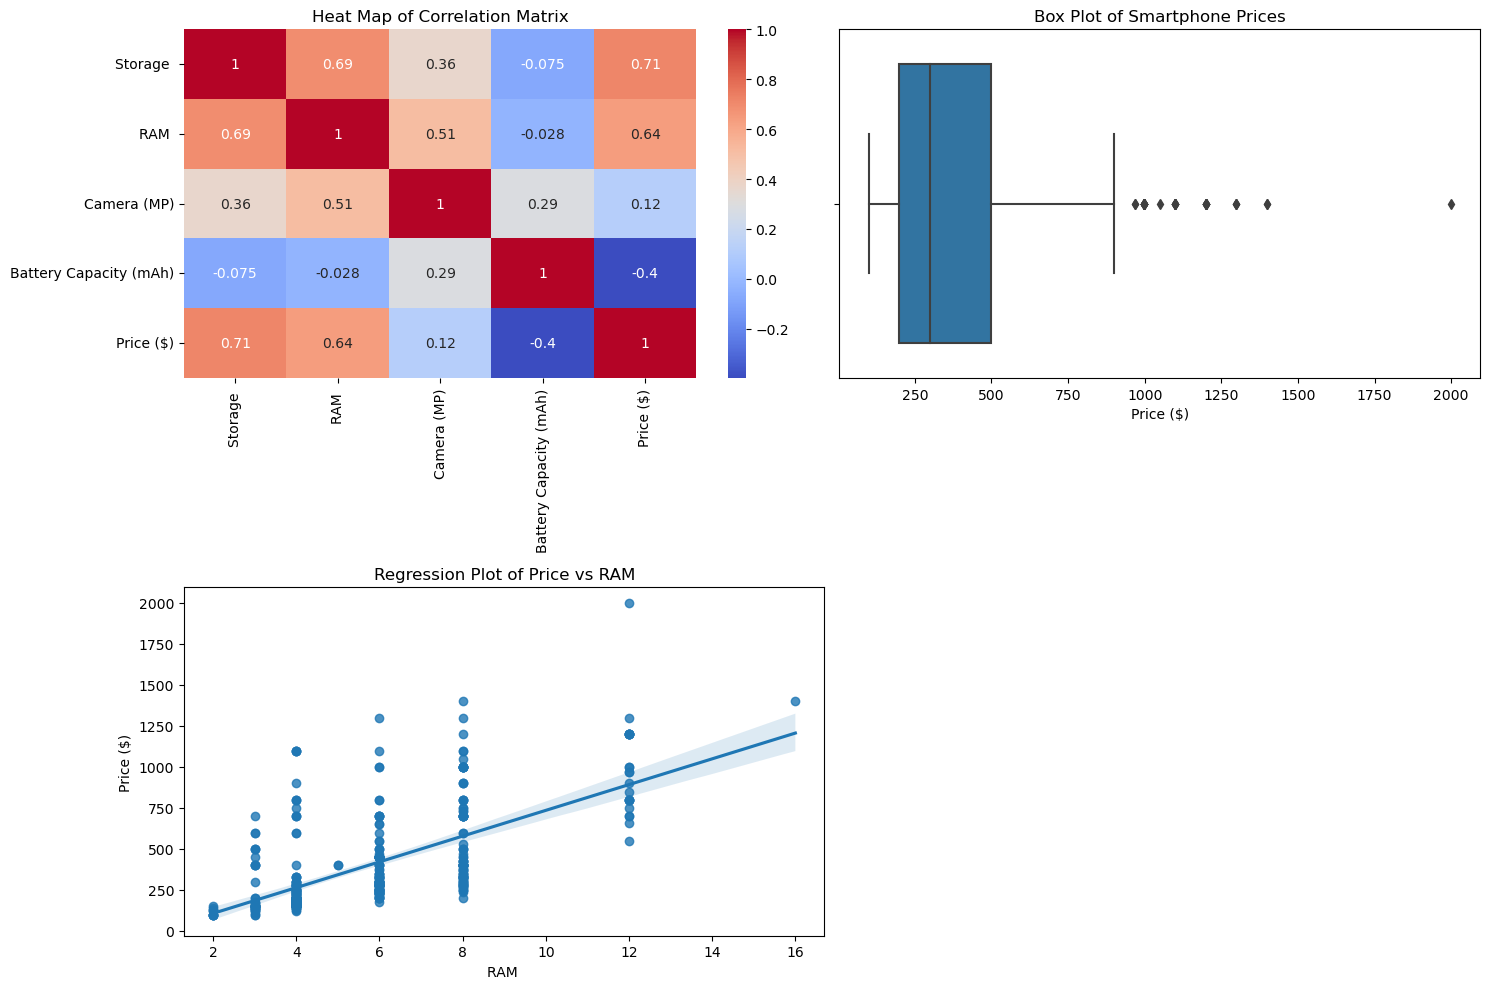

         Storage         RAM   Camera (MP)  Battery Capacity (mAh)  \
count  407.000000  407.000000   407.000000              407.000000   
mean   123.046683    5.837838    43.316953             4676.476658   
std     64.963160    2.431980    24.672141              797.193713   
min     32.000000    2.000000     8.000000             1821.000000   
25%     64.000000    4.000000    13.000000             4300.000000   
50%    128.000000    6.000000    48.000000             5000.000000   
75%    128.000000    8.000000    64.000000             5000.000000   
max    512.000000   16.000000   108.000000             7000.000000   

         Price ($)  
count   407.000000  
mean    408.314496  
std     299.684768  
min      99.000000  
25%     199.000000  
50%     299.000000  
75%     499.000000  
max    1999.000000  


In [16]:
# Descriptive Statistics
descriptive_stats = df.describe()

# Correlation Matrix for Heat Map
correlation_matrix = df[numeric_cols].corr()  # Use only numeric columns for correlation

# Creating the plots
plt.figure(figsize=(15, 10))

# Heat Map
plt.subplot(2, 2, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heat Map of Correlation Matrix')

# Box Plot for Price
plt.subplot(2, 2, 2)
sns.boxplot(x=df['Price ($)'])
plt.title('Box Plot of Smartphone Prices')

# Regression Plot for Price and RAM
plt.subplot(2, 2, 3)
sns.regplot(x='RAM ', y='Price ($)', data=df)
plt.title('Regression Plot of Price vs RAM')

plt.tight_layout()
plt.show()

# Outputting Descriptive Statistics
print(descriptive_stats)

# Data Preprocessing for Machine Learning

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler


# Identify categorical columns (excluding 'Price ($)')
categorical_cols = df.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding to categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
df_encoded = ct.fit_transform(df.drop(columns=['Price ($)']))

# Convert the output to a dense format
df_encoded_dense = df_encoded.toarray()

# Define the target variable (Price)
y = df['Price ($)']

# Normalization of all features
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_encoded_dense))

# Output the transformed dataframe
print(df_normalized.head())


   0    1    2    3    4    5    6    7    8    9    ...  290  291  292  293  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   294  295       296       297   298       299  
0  0.0  0.0  0.200000  0.285714  0.04  0.245993  
1  0.0  0.0  0.466667  0.714286  1.00  0.613825  
2  0.0  0.0  0.200000  0.428571  0.40  0.517281  
3  0.0  0.0  0.200000  0.285714  0.56  0.617687  
4  0.0  0.0  0.200000  0.428571  0.42  0.539293  

[5 rows x 300 columns]


# Model Training: Ridge and Random Forest Regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_normalized, y, test_size=0.2, random_state=42)

# Linear Regression Model (using Ridge Regression for regularization)
ridge_reg = Ridge(alpha=1.0)  # You can adjust the alpha value
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

# Random Forest Regression Model
random_forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_reg.fit(X_train, y_train)
y_pred_rf = random_forest_reg.predict(X_test)





# Model Evaluation

In [20]:

# Evaluating the models
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Output the evaluation metrics for both models
print("Ridge Regression Evaluation:")
print(f"Mean Squared Error (MSE): {mse_ridge}")
print(f"R-squared (R2): {r2_ridge}\n")

print("Random Forest Regression Evaluation:")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R2): {r2_rf}\n")

# Determine the best model based on R2 and MSE
best_model = "Ridge Regression" if r2_ridge > r2_rf and mse_ridge < mse_rf else "Random Forest Regression"
print(f"The best model for the dataset based on the evaluation metrics is: {best_model}")


Ridge Regression Evaluation:
Mean Squared Error (MSE): 12312.193594910426
R-squared (R2): 0.865269522615475

Random Forest Regression Evaluation:
Mean Squared Error (MSE): 7257.579289100009
R-squared (R2): 0.9205814045451094

The best model for the dataset based on the evaluation metrics is: Random Forest Regression
